# import libraries

In [1]:
# Remove some warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import math
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define functions and classes

## Image class

In [3]:
class Img:
    def __init__(self, link):
        self.original_img = Image.open(link)
        self.dimension = self.original_img.size
        
    def resize(self):
        print(self.dimension[0]/self.dimension[1])
        self.img = self.original_img.resize((50,int(50/(self.dimension[0]/self.dimension[1]))),Image.ANTIALIAS)
        self.dimension = self.img.size
        
    def toArray(self):
        self.resize()
        self.img = np.array(self.img, dtype=np.float64) / 255
        
        self.w, self.h, self.d = self.img.shape
        assert self.d == 3 # make sure we're dealing with a color image RGB
        self.imgArray = self.img.reshape(self.w * self.h, self.d)
        
        print( f"There are {len( np.unique(self.imgArray, axis=0))} distinct colors on {self.w*self.h} pixels" )
        
    def plot(self):
        self.resize()
        plt.imshow(self.img)

## Kernel class

In [4]:
class flatKernel:
    def __call__(self, bandwidth, dis):
        return (dis < bandwidth).astype(int)

## Distance function

In [5]:
def euclidean_distance(x, y):
    return math.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2)

## Mean-shift Class

In [6]:
class MeanShift:
    def __init__(self, threshold=1e-6, bandwidth=1, kernel=flatKernel(), distance_func=euclidean_distance):
        self.threshold = threshold
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.distance_func = distance_func
        self.clusterCenter = []
        self.labels_meanshift = []
        
    def estimateBandwidth(self, data, k):
        n = data.shape[0]  
        distances = np.zeros((n, n))  
        
        for i in range(n):
            for j in range(n):
                distances[i, j] = euclidean_distance(data[i], data[j])

        sorted_distances = np.sort(distances, axis=1)
        nearest_neighbors = sorted_distances[:, 1:k+1] 
        
        self.bandwidth = np.mean(nearest_neighbors)

        return self.bandwidth
        
    def shiftMode(self, data, pre, bandwidth):
        numerator = 0
        denominator = 0
        for x in data:
            kernel_value = self.kernel(bandwidth, self.distance_func(x, pre))
            numerator += x * kernel_value
            denominator += kernel_value
        mode = numerator / denominator
        return mode
    
    def MS(self, image):
        data = image.imgArray
        start_time = datetime.now()
        self.w = image.w
        self.h = image.h
        self.d = image.d
        n = len(data)
        mode = []
        for i in range(n):
            m = 0
            current_mode = [data[i]]
            flag = True
            if i % 500 == 0:
                print(f"{int((i/n)*100)}%", end=" ==> ")
            while flag:
                current_mode.append(self.shiftMode(data, current_mode[m], self.bandwidth)) 
                m += 1
                if self.distance_func(current_mode[m], current_mode[m-1]) < self.threshold:
                    flag = False
            mode.append(current_mode[m])
            
        self.clusterCenter = np.unique(np.array(mode), axis=0)
        self.labels_meanshift = np.array(mode)
        
        unique_labels = np.unique(self.labels_meanshift)
        self.cluster_name = np.zeros(len(self.labels_meanshift), dtype=int)

        for i, label in enumerate(unique_labels):
            self.cluster_name[np.where(self.labels_meanshift == label)[0]] = i
        
        end_time = datetime.now()    
        print('Duration: {}'.format(end_time - start_time))
            
        # return self.labels_meanshift
    
    def plot(self):
        plt.title('Image quantify for %d colors mean shift clustering' % len( np.unique(self.labels_meanshift, axis=0)))
        plt.imshow(np.array(self.labels_meanshift).reshape(self.w, self.h, self.d))

# Main

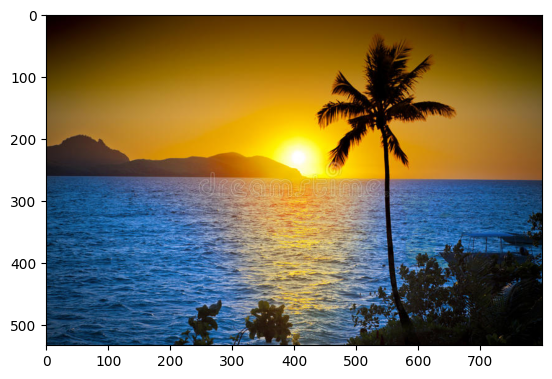

In [7]:
image = Img("sun.jpg")
plt.imshow(image.original_img)

## resize image

In [8]:
image.resize()

1.5009380863039399


1.5151515151515151


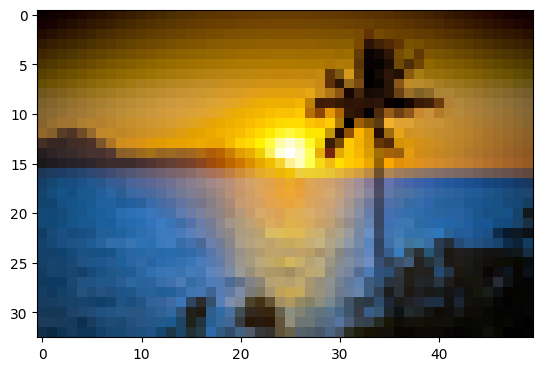

In [9]:
image.plot()

## convert image to array

In [10]:
image.toArray()

1.5151515151515151
There are 1605 distinct colors on 1650 pixels


## define Mean-shift

In [11]:
ms = MeanShift()

## estimate the bandwidth

In [12]:
start_time = datetime.now()
ms.estimateBandwidth(image.imgArray, 30)
end_time = datetime.now()    
print('Duration for estimate bandwidth time: {}'.format(end_time - start_time))

Duration for estimate bandwidth time: 0:00:04.559998


## mean-shift

In [13]:
ms.MS(image)

0% ==>30% ==>60% ==>90% ==>Duration: 0:01:20.192030


## plot the image after mean-shift

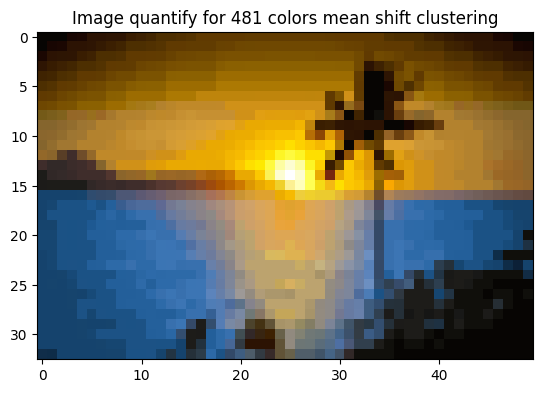

In [14]:
ms.plot()

(-0.5, 49.5, 32.5, -0.5)

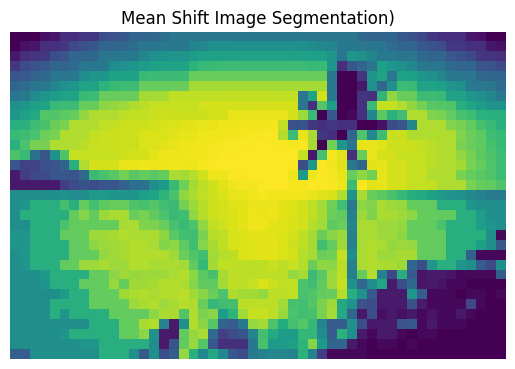

In [15]:
plt.imshow(ms.cluster_name.reshape(ms.w, ms.h))
plt.title('Mean Shift Image Segmentation)')
plt.axis('off')